Optimal bet multiplier: 7.28
Best average balance: 1442.7881536000034


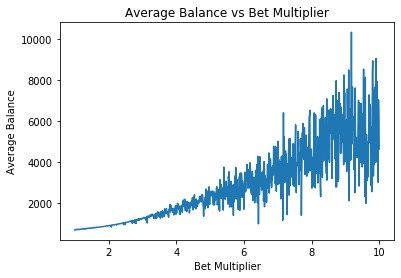

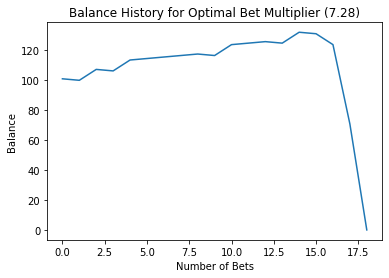

Optimal bet multiplier has won 11 times and lost 8 times in 1000 bets.


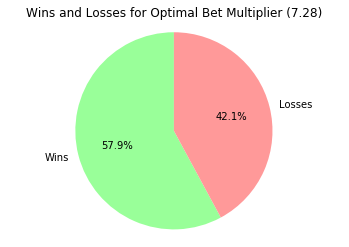

In [3]:
import random
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp

class MartingaleStrategy:
    def __init__(self, initial_bet, win_probability, num_bets, budget):
        self.initial_bet = initial_bet
        self.win_probability = win_probability
        self.num_bets = num_bets
        self.budget = budget

    def simulate_betting_strategy(self, bet_multiplier, return_history=False, return_stats=False):
        bet_amount = self.initial_bet
        balance = self.budget
        wins = 0
        losses = 0
        balance_history = []

        for _ in range(self.num_bets):
            if balance <= 0:
                break

            won_bet = random.random() < self.win_probability

            if won_bet:
                bet_amount = min(bet_amount, balance)
                balance += bet_amount
                wins += 1
                bet_amount = self.initial_bet
            else:
                bet_amount = min(bet_amount, balance)
                balance -= bet_amount
                losses += 1
                bet_amount *= bet_multiplier

            balance_history.append(balance)

        result = (balance,)
        if return_history:
            result += (balance_history,)
        if return_stats:
            result += (wins, losses)

        return result if len(result) > 1 else result[0]

    def _run_trials(self, bet_multiplier, trials_per_combination):
        total_balance = 0
        total_wins = 0
        total_losses = 0

        for _ in range(trials_per_combination):
            balance, wins, losses = self.simulate_betting_strategy(bet_multiplier, return_history=False, return_stats=True)
            total_balance += balance
            total_wins += wins
            total_losses += losses

        avg_balance = total_balance / trials_per_combination
        return bet_multiplier, avg_balance, total_wins, total_losses


    def optimize_bet_multiplier(self, trials_per_combination, min_multiplier, max_multiplier, step_size, min_win_percentage):
        optimal_multiplier = 0
        best_avg_balance = -float('inf')
        least_losses = float('inf')
        results = []

        pool = mp.Pool(mp.cpu_count())
        trials_args = [(bet_multiplier, trials_per_combination) for bet_multiplier in np.arange(min_multiplier, max_multiplier + step_size, step_size)]
        results = pool.starmap(self._run_trials, trials_args)
        pool.close()

        avg_balances = []

        for bet_multiplier, avg_balance, wins, losses in results:
            avg_balances.append(avg_balance)

            total_bets = wins + losses
            win_percentage = wins / total_bets if total_bets > 0 else 0

            # Check if the bet multiplier satisfies the minimum win percentage condition
            if win_percentage >= min_win_percentage:
                if losses < least_losses:
                    least_losses = losses
                    best_avg_balance = avg_balance
                    optimal_multiplier = bet_multiplier
                elif losses == least_losses and avg_balance > best_avg_balance:
                    best_avg_balance = avg_balance
                    optimal_multiplier = bet_multiplier

        return optimal_multiplier, best_avg_balance, avg_balances




initial_bet = 1
win_probability = 0.8
num_bets = 1000
budget = 100
trials_per_combination = 10
min_multiplier = 1.00
max_multiplier = 10.00
step_size = 0.01
min_win_percentage = 0.5

betting_strategy = MartingaleStrategy(initial_bet, win_probability, num_bets, budget)
optimal_multiplier, best_avg_balance, avg_balances = betting_strategy.optimize_bet_multiplier(trials_per_combination, min_multiplier, max_multiplier, step_size, min_win_percentage)

print(f"Optimal bet multiplier: {optimal_multiplier:.2f}")
print(f"Best average balance: {best_avg_balance}")

# Plot the average balance for each tested multiplier
multipliers = np.arange(min_multiplier, max_multiplier + step_size, step_size)
plt.plot(multipliers, avg_balances)
plt.xlabel('Bet Multiplier')
plt.ylabel('Average Balance')
plt.title('Average Balance vs Bet Multiplier')
plt.show()

# Plot the balance history for the optimal bet multiplier
_, optimal_balance_history, wins, losses = betting_strategy.simulate_betting_strategy(optimal_multiplier, return_history=True, return_stats=True)
plt.plot(optimal_balance_history)
plt.xlabel('Number of Bets')
plt.ylabel('Balance')
plt.title(f'Balance History for Optimal Bet Multiplier ({optimal_multiplier:.2f})')
plt.show()

print(f"Optimal bet multiplier has won {wins} times and lost {losses} times in {num_bets} bets.")

# Pie chart for the optimal bet multiplier's wins and losses
labels = ['Wins', 'Losses']
sizes = [wins, losses]
colors = ['#99ff99', '#ff9999']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title(f"Wins and Losses for Optimal Bet Multiplier ({optimal_multiplier:.2f})")
plt.show()